In [1]:
import pandas
import seaborn
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

# Fetches and parses the cleaned up dataset from phase 2.
data = pandas.read_csv("https://raw.githubusercontent.com/SuperChentao/creditDataProcessing/master/german_credit.csv")

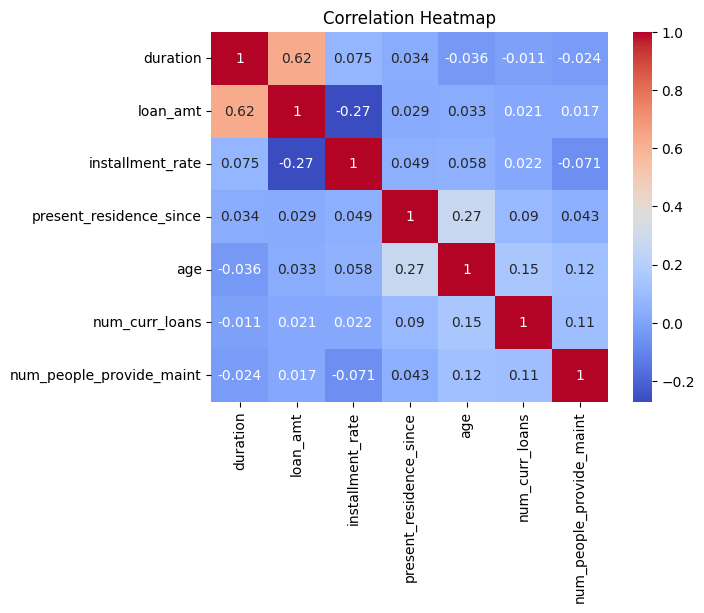

In [2]:
# A good first step is to generate a correlation graph using the numerical attributes.
seaborn.heatmap(data.select_dtypes(include='int64').corr(), annot=True, cmap='coolwarm')
matplotlib.pyplot.title('Correlation Heatmap')
matplotlib.pyplot.show()

# As shown in the figure, there is virtually no correlation between the the attributes which indicates that there is 
# probably no redundancy. The only exception is Loan Amount and Loan Duration with a correlation factor of 0.62.

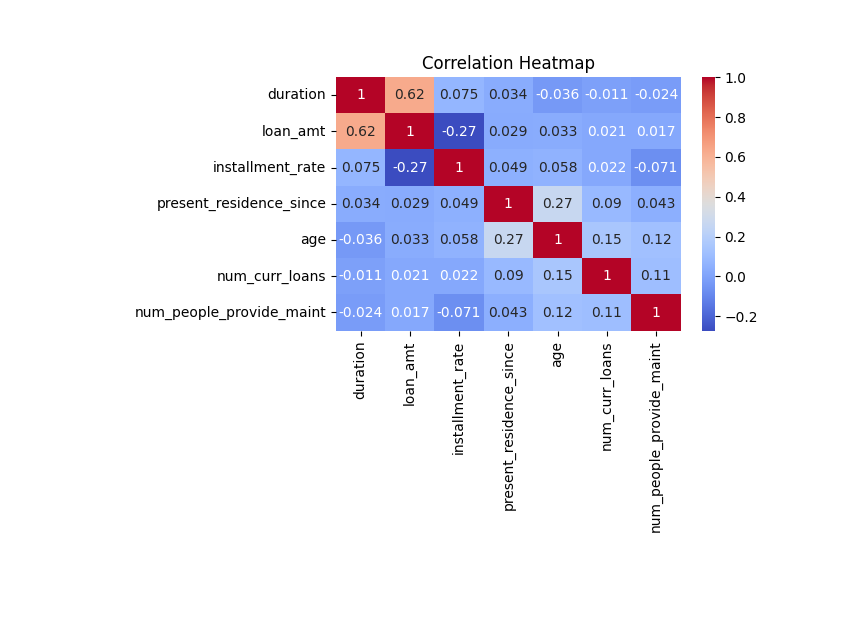

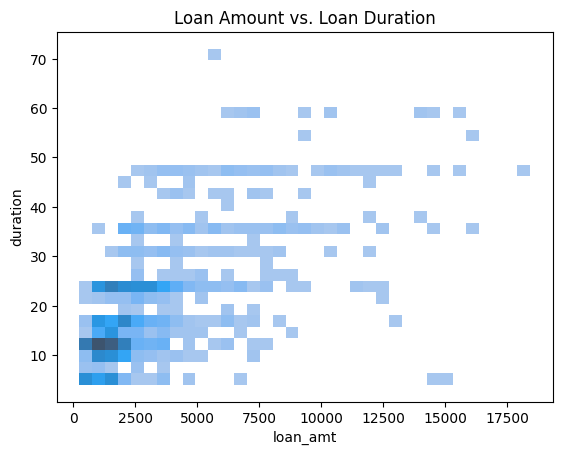

In [3]:
# We can then plot a heightmap histogram to get an idea of how loan amount and duration correlate with each other.
seaborn.histplot(data=data, x='loan_amt', y='duration')
matplotlib.pyplot.title('Loan Amount vs. Loan Duration')
matplotlib.pyplot.show()

# As can be seen, a higher loan amount will naturally take longer to repay (on average) hence the generate trend upwards.
# However, the correlation is small enough that this should not cause any problems or require special attention.

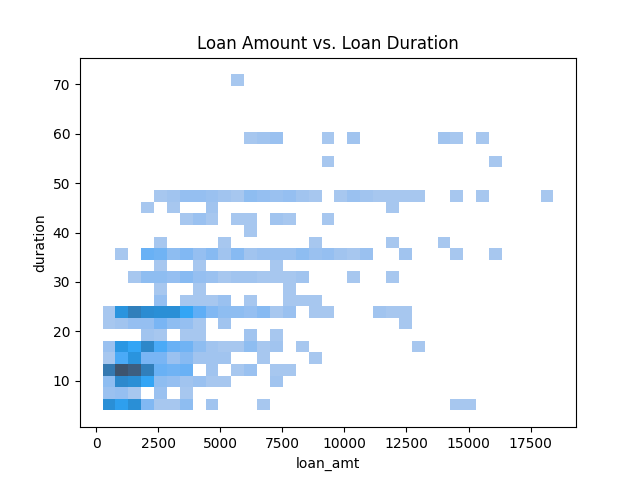

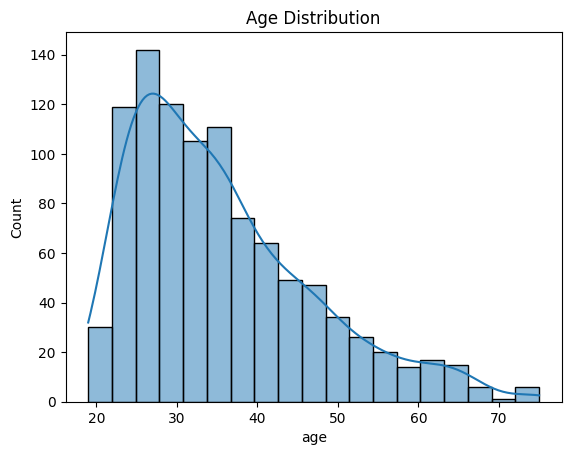

In [4]:
# Another interesting statistic is the age distribution of borrowers.
seaborn.histplot(data['age'], kde=True)
matplotlib.pyplot.title('Age Distribution')
matplotlib.pyplot.show()

# Most borrowers are in their late 20s or 30s.

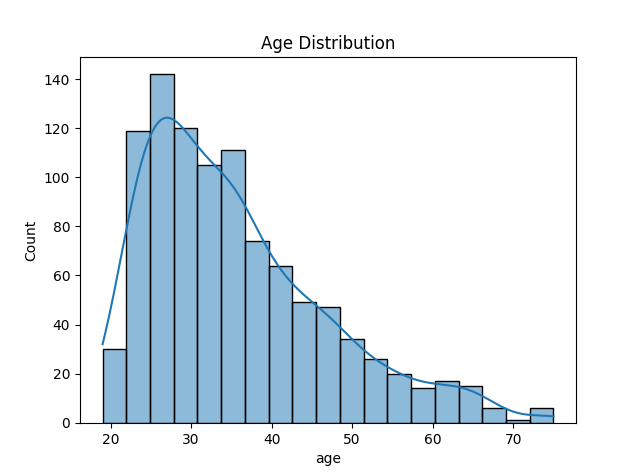

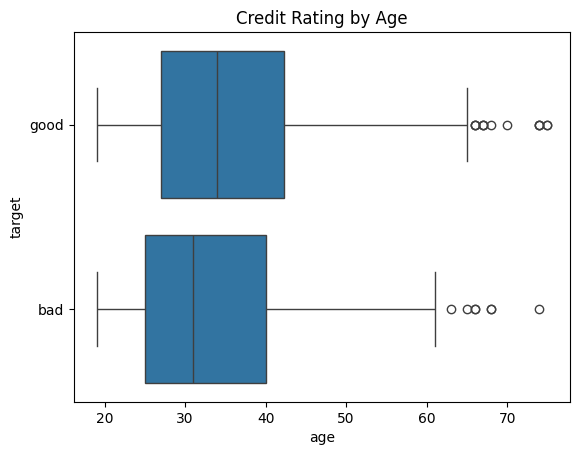

In [5]:
# It is then possible to look at credit rating by age using a boxplot.
seaborn.boxplot(x='age', y='target', data=data)
matplotlib.pyplot.title('Credit Rating by Age')
matplotlib.pyplot.show()

# It is the case that younger borrowers usually have worse credit rating than older borrowers.

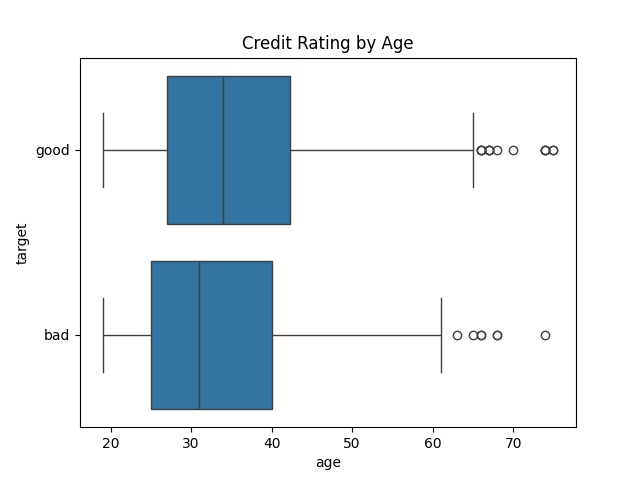

In [6]:
# We will now pre-process the dataset to get it ready for classification using supervised machine learning.

# Print the column information below.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_acc_status       1000 non-null   object
 1   duration                  1000 non-null   int64 
 2   cred_hist                 1000 non-null   object
 3   purpose                   1000 non-null   object
 4   loan_amt                  1000 non-null   int64 
 5   saving_acc_bonds          1000 non-null   object
 6   present_employment_since  1000 non-null   object
 7   installment_rate          1000 non-null   int64 
 8   personal_stat_gender      1000 non-null   object
 9   other_debtors_guarantors  1000 non-null   object
 10  present_residence_since   1000 non-null   int64 
 11  property                  1000 non-null   object
 12  age                       1000 non-null   int64 
 13  other_installment_plans   1000 non-null   object
 14  housing                  

In [7]:
# There are no missing or null values in the dataset, therefore no imputation is needed.

In [8]:
# There are 14 categorical columns unsuitable for direct use in machine learning models due to their non-numeric nature. 
# One-hot encoding is an effective solution to address this, especially since these categories have low cardinality.

# The get_dummies function implements on-hot encoding on the dataset. The drop_first flag is True for a couple of reasons.
#
#  (1) It eliminates the number of dimensions. In this case, the dataset will be used for a categorization machine 
#      learning task (good credit = true or false) therefore having fewer dimensions is advantageous to mitigate the 
#      risk of overfitting.
#
#  (2) It reduces multicollinearity. For example, 2 columns for is_foreign_worker_yes and is_foreign_worker_no are 
#      highly correlated. If the value is true for one, it is always false for the other. This redundancy breaks the 
#      interpretability of linear models that use any form of regression and causes performance slowdowns for tree-based 
#      models.
data = pandas.get_dummies(data, drop_first=True)

# Print the column information below.
print(data.info())

# The 14 categorical columns were expanded into 42 boolean columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   duration                                      1000 non-null   int64
 1   loan_amt                                      1000 non-null   int64
 2   installment_rate                              1000 non-null   int64
 3   present_residence_since                       1000 non-null   int64
 4   age                                           1000 non-null   int64
 5   num_curr_loans                                1000 non-null   int64
 6   num_people_provide_maint                      1000 non-null   int64
 7   checking_acc_status_below_0                   1000 non-null   bool 
 8   checking_acc_status_below_200                 1000 non-null   bool 
 9   checking_acc_status_no_cheking_acc            1000 non-null   bool 
 10  cred_hist_del

In [9]:
# There are 7 numerical columns unsuitable for direct use in machine learning models due to the lack of normalization.
# Without it, a feature with a large scale (like salary) can dominate the learning process potentially leading to a model 
# that is biased towards that feature instead of other features with smaller magnitudes (like age or loan duration).

# StandardScaler is unecessary are most of the features do not need to be interpreted as having a random distribution. 
# RobustScaler is also not needed as there are no outliers. A simple MinMaxScaler is sufficient and provides a more rigid 
# bound for the distribution (between 0 and 1).
scaler = MinMaxScaler()
# Numerical columns are selected.
numerical_columns = data.select_dtypes(include='int64')
# Dataset is updated with the normalized columns.
data[numerical_columns.columns] = scaler.fit_transform(numerical_columns)

In [10]:
# As a last step, significant outliers can be removed from the dataset.

# Create One-Class SVM object model with nu=0.01.
svm = OneClassSVM(nu=0.01, gamma='auto').fit(data)
outliers = data[svm.predict(data) == -1]

# Print the outliers below.
print(outliers)

# The One-Class SVM Model with bounds nu=0.01 produced 17 outliers from the 1000 data points.
'''
     duration  loan_amt  installment_rate  present_residence_since       age  num_curr_loans  num_people_provide_maint  checking_acc_status_below_0  checking_acc_status_below_200  checking_acc_status_no_cheking_acc  cred_hist_delay_in_past  cred_hist_no_loan_or_paid_duly_other  cred_hist_paid_duly_this_bank  cred_hist_risky_acc_or_curr_loan_other  purpose_car_new  purpose_car_used  purpose_domestic_applience  purpose_education  purpose_furniture_equipment  purpose_others  purpose_radio_tv  purpose_repairs  purpose_retraining  saving_acc_bonds_below_100  saving_acc_bonds_below_1000  saving_acc_bonds_below_500  saving_acc_bonds_unknown_no_saving_acc  present_employment_since_below_1y  present_employment_since_below_4y  present_employment_since_below_7y  present_employment_since_unemployed  personal_stat_gender_male:divorced  personal_stat_gender_male:married_or_widowed  personal_stat_gender_male:single  other_debtors_guarantors_guarantor  other_debtors_guarantors_none  property_life_insurance_or_aggreements  property_real_estate  property_unknown_or_no_property  other_installment_plans_none  other_installment_plans_store  housing_own  housing_rent  job_skilled_official  job_unemployed_non_resident  job_unskilled_resident  telephone_yes  is_foreign_worker_yes  target_good
55   0.029412  0.029328          0.000000                 0.333333  0.125000        0.000000                       1.0                        False                          False                                True                    False                                 False                           True                                   False             True             False                       False              False                        False           False             False            False               False                       False                        False                       False                                    True                              False                               True                              False                                False                               False                                         False                              True                                True                          False                                   False                  True                            False                         False                           True         True         False                 False                        False                    True          False                   True         True
59   0.470588  0.328986          1.000000                 1.000000  0.071429        0.333333                       0.0                         True                          False                               False                    False                                 False                          False                                    True            False             False                       False              False                         True           False             False            False               False                        True                        False                       False                                   False                               True                              False                              False                                False                               False                                         False                             False                               False                          False                                   False                 False                             True                          True                          False        False          True                 False                        False                    True           True                   True        False
99   0.235294  0.374546          0.666667                 1.000000  0.303571        0.333333                       1.0                        False                           True                               False                     True                                 False                          False                                   False            False              True                       False              False                        False           False             False            False               False                       False                        False                       False                                    True                              False                              False                               True                                False                               False                                         False                              True                               False                           True                                    True                 False                            False                         False                          False        False          True                 False                        False                   False           True                   True         True
138  0.161765  0.136349          1.000000                 0.333333  0.285714        0.666667                       0.0                        False                           True                               False                    False                                 False                          False                                    True            False             False                       False              False                        False           False              True            False               False                       False                        False                       False                                    True                              False                              False                               True                                False                               False                                         False                              True                                True                          False                                   False                  True                            False                         False                          False         True         False                  True                        False                   False           True                   True         True
156  0.073529  0.057115          0.666667                 1.000000  0.517857        0.333333                       1.0                         True                          False                               False                    False                                 False                          False                                    True            False             False                       False              False                        False           False             False             True               False                       False                        False                        True                                   False                              False                              False                              False                                False                               False                                         False                              True                                True                          False                                   False                  True                            False                          True                          False         True         False                  True                        False                   False          False                  False         True
247  0.029412  0.052493          1.000000                 0.000000  0.285714        0.000000                       0.0                        False                          False                                True                    False                                  True                          False                                   False             True             False                       False              False                        False           False             False            False               False                       False                        False                        True                                   False                              False                               True                              False                                False                               False                                         False                              True                               False                           True                                   False                 False                             True                         False                          False        False          True                  True                        False                   False          False                  False         True
272  0.647059  0.655827          1.000000                 1.000000  0.303571        0.000000                       0.0                        False                           True                               False                    False                                 False                           True                                   False             True             False                       False              False                        False           False             False            False               False                       False                        False                       False                                    True                              False                              False                              False                                 True                               False                                         False                              True                               False                          False                                   False                 False                             True                          True                          False        False         False                 False                        False                   False           True                   True         True
274  0.382353  0.646418          0.000000                 0.000000  0.267857        0.000000                       0.0                         True                          False                               False                    False                                 False                          False                                   False            False             False                       False              False                        False           False             False             True               False                        True                        False                       False                                   False                               True                              False                              False                                False                                True                                         False                             False                               False                           True                                   False                 False                             True                          True                          False         True         False                 False                        False                    True           True                   True        False
289  0.294118  0.042588          1.000000                 1.000000  0.517857        0.000000                       0.0                         True                          False                               False                     True                                 False                          False                                   False            False             False                       False              False                        False           False              True            False               False                        True                        False                       False                                   False                               True                              False                              False                                False                               False                                          True                             False                               False                           True                                   False                  True                            False                         False                           True         True         False                  True                        False                   False          False                   True        False
347  0.294118  0.193023          0.000000                 1.000000  0.071429        0.000000                       0.0                        False                           True                               False                    False                                 False                          False                                   False            False             False                       False              False                        False           False              True            False               False                       False                         True                       False                                   False                              False                              False                              False                                 True                               False                                         False                             False                               False                           True                                   False                 False                             True                          True                          False        False          True                 False                         True                   False          False                   True         True
513  0.117647  0.018433          1.000000                 1.000000  0.017857        0.333333                       0.0                        False                           True                               False                     True                                 False                          False                                   False            False             False                       False              False                        False           False              True            False               False                        True                        False                       False                                   False                              False                               True                              False                                False                               False                                          True                             False                               False                          False                                   False                  True                            False                          True                          False        False          True                  True                        False                   False          False                   True         True
552  0.647059  0.371355          0.000000                 0.000000  0.267857        0.333333                       0.0                         True                          False                               False                    False                                 False                          False                                   False            False             False                       False              False                        False           False              True            False               False                        True                        False                       False                                   False                              False                              False                               True                                False                               False                                          True                             False                                True                          False                                   False                  True                            False                          True                          False         True         False                  True                        False                   False           True                   True        False
561  0.294118  0.071311          1.000000                 1.000000  0.089286        0.000000                       0.0                         True                          False                               False                    False                                 False                           True                                   False            False             False                       False              False                        False           False              True            False               False                        True                        False                       False                                   False                              False                              False                               True                                False                               False                                         False                              True                                True                          False                                   False                 False                            False                         False                          False        False          True                 False                        False                    True          False                   True        False
595  0.029412  0.037471          0.000000                 0.000000  0.232143        0.000000                       0.0                        False                           True                               False                    False                                 False                           True                                   False             True             False                       False              False                        False           False             False            False               False                       False                        False                        True                                   False                               True                              False                              False                                False                               False                                         False                             False                               False                           True                                    True                 False                            False                         False                           True         True         False                 False                        False                    True          False                   True        False
663  0.029412  0.044019          1.000000                 0.000000  0.285714        0.333333                       0.0                        False                           True                               False                     True                                 False                          False                                   False            False             False                       False              False                         True           False             False            False               False                        True                        False                       False                                   False                              False                              False                              False                                 True                               False                                         False                              True                               False                           True                                    True                 False                            False                         False                           True         True         False                 False                        False                   False           True                   True         True
816  0.029412  0.059866          0.000000                 1.000000  0.767857        0.000000                       0.0                        False                          False                                True                    False                                 False                          False                                   False            False             False                        True              False                        False           False             False            False               False                       False                         True                       False                                   False                              False                               True                              False                                False                                True                                         False                             False                               False                           True                                   False                  True                            False                          True                          False         True         False                  True                        False                   False          False                   True         True
927  0.647059  0.552823          1.000000                 1.000000  0.357143        0.666667                       1.0                         True                          False                               False                    False                                 False                          False                                   False            False              True                       False              False                        False           False             False            False               False                        True                        False                       False                                   False                              False                              False                               True                                False                               False                                         False                              True                               False                           True                                   False                 False                             True                         False                           True        False         False                  True                        False                   False           True                   True        False
'''

     duration  loan_amt  installment_rate  present_residence_since       age  \
55   0.029412  0.029328          0.000000                 0.333333  0.125000   
59   0.470588  0.328986          1.000000                 1.000000  0.071429   
99   0.235294  0.374546          0.666667                 1.000000  0.303571   
138  0.161765  0.136349          1.000000                 0.333333  0.285714   
156  0.073529  0.057115          0.666667                 1.000000  0.517857   
247  0.029412  0.052493          1.000000                 0.000000  0.285714   
272  0.647059  0.655827          1.000000                 1.000000  0.303571   
274  0.382353  0.646418          0.000000                 0.000000  0.267857   
289  0.294118  0.042588          1.000000                 1.000000  0.517857   
347  0.294118  0.193023          0.000000                 1.000000  0.071429   
513  0.117647  0.018433          1.000000                 1.000000  0.017857   
552  0.647059  0.371355          0.00000

'\n     duration  loan_amt  installment_rate  present_residence_since       age  num_curr_loans  num_people_provide_maint  checking_acc_status_below_0  checking_acc_status_below_200  checking_acc_status_no_cheking_acc  cred_hist_delay_in_past  cred_hist_no_loan_or_paid_duly_other  cred_hist_paid_duly_this_bank  cred_hist_risky_acc_or_curr_loan_other  purpose_car_new  purpose_car_used  purpose_domestic_applience  purpose_education  purpose_furniture_equipment  purpose_others  purpose_radio_tv  purpose_repairs  purpose_retraining  saving_acc_bonds_below_100  saving_acc_bonds_below_1000  saving_acc_bonds_below_500  saving_acc_bonds_unknown_no_saving_acc  present_employment_since_below_1y  present_employment_since_below_4y  present_employment_since_below_7y  present_employment_since_unemployed  personal_stat_gender_male:divorced  personal_stat_gender_male:married_or_widowed  personal_stat_gender_male:single  other_debtors_guarantors_guarantor  other_debtors_guarantors_none  property_life_i

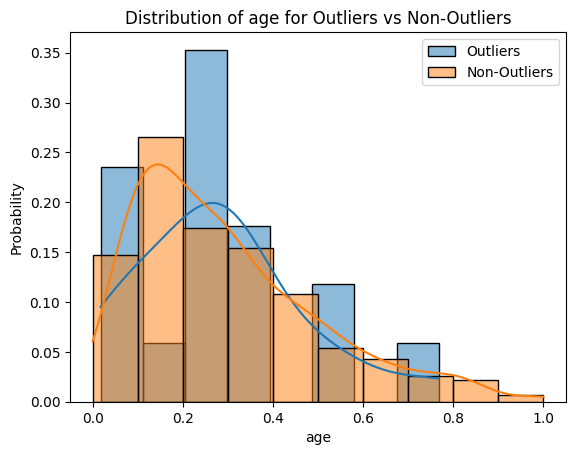

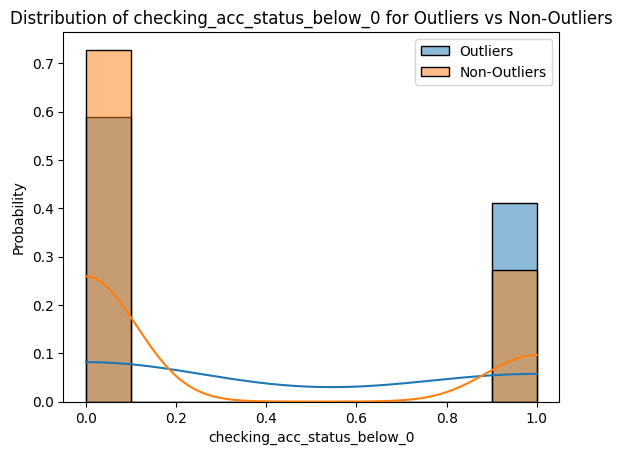

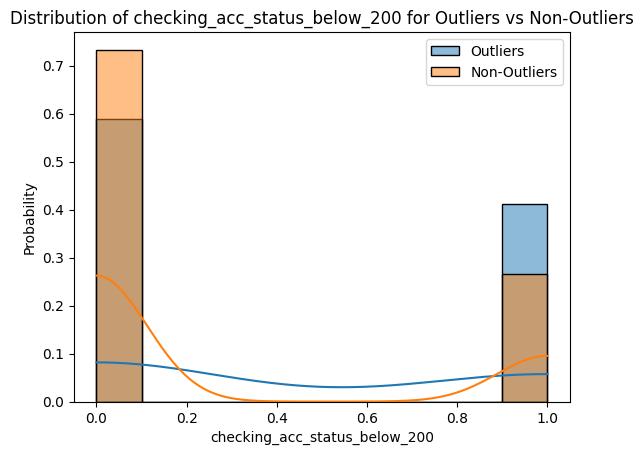

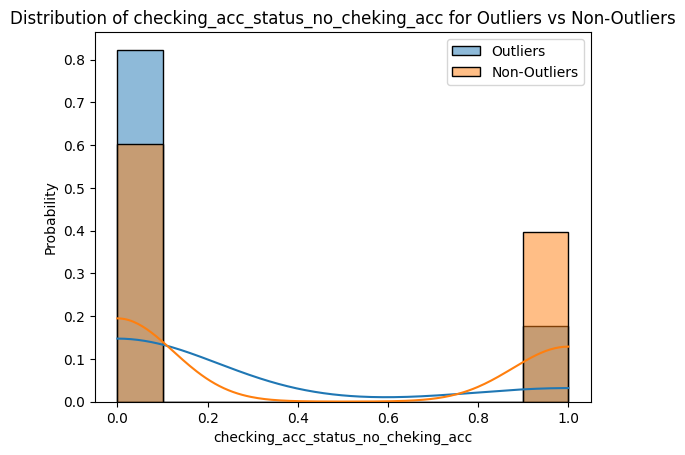

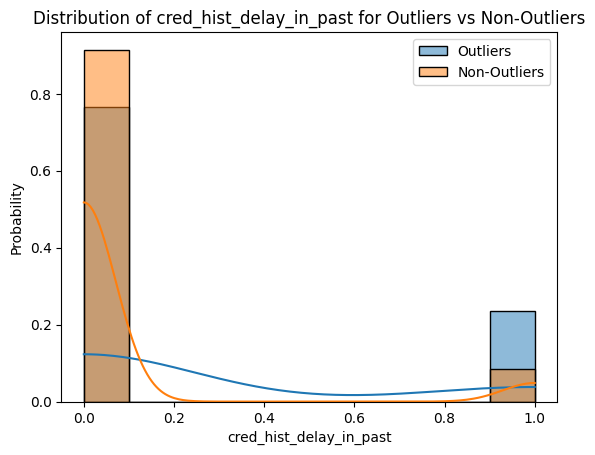

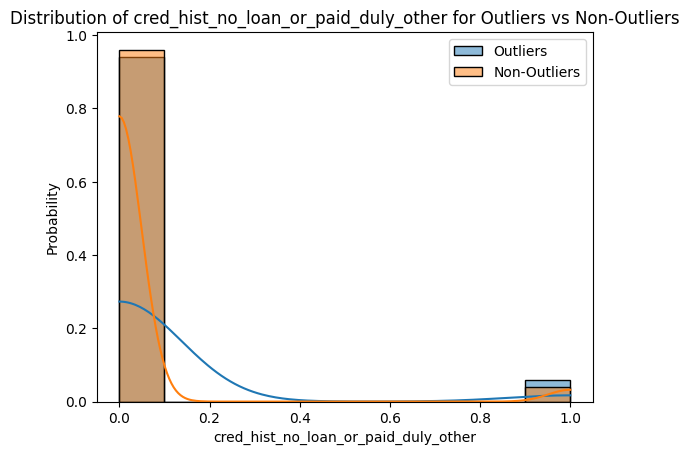

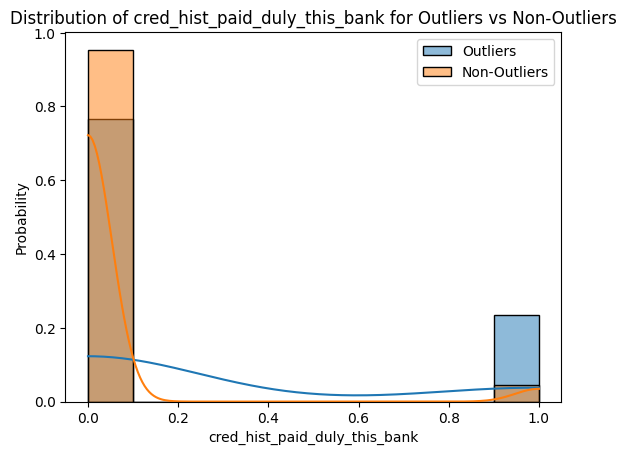

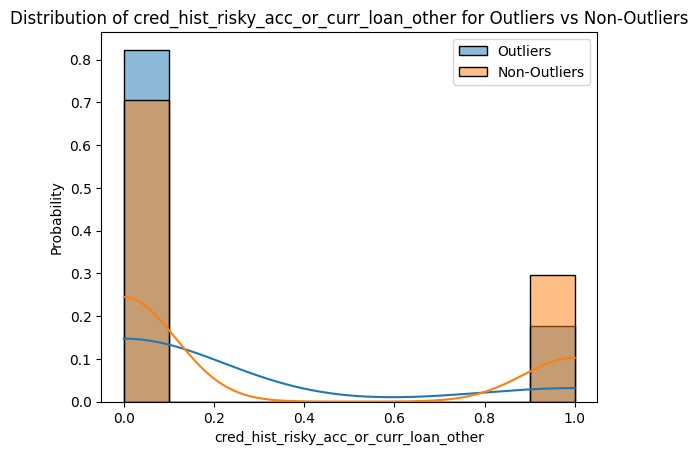

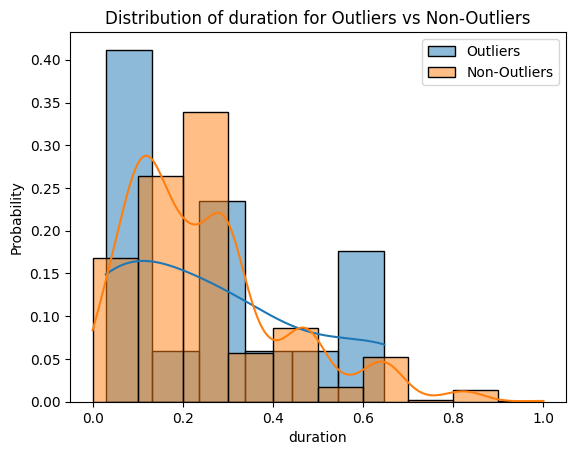

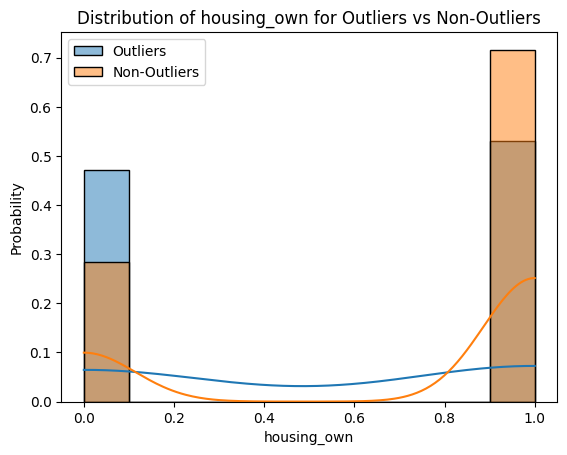

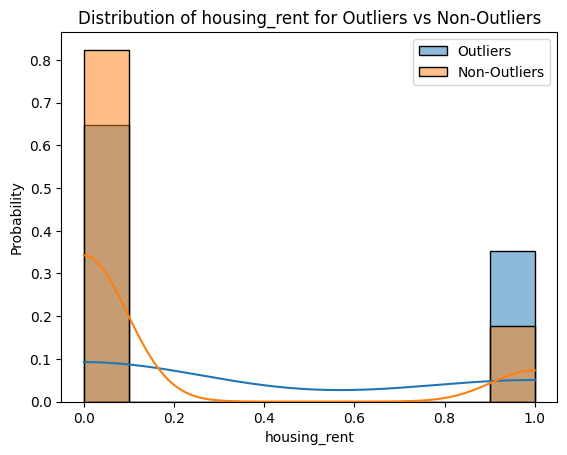

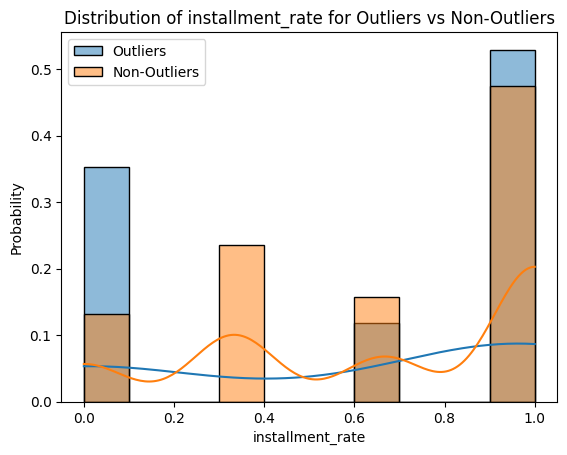

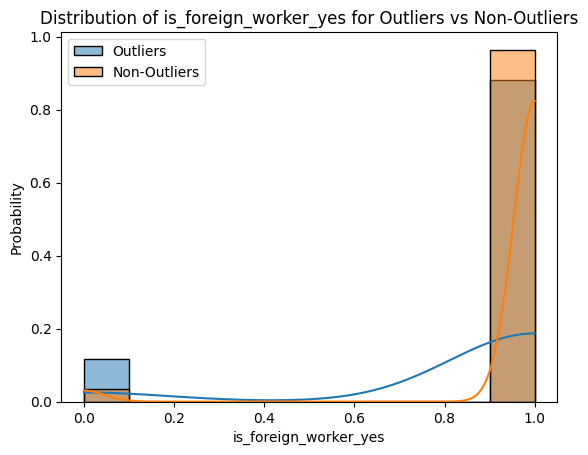

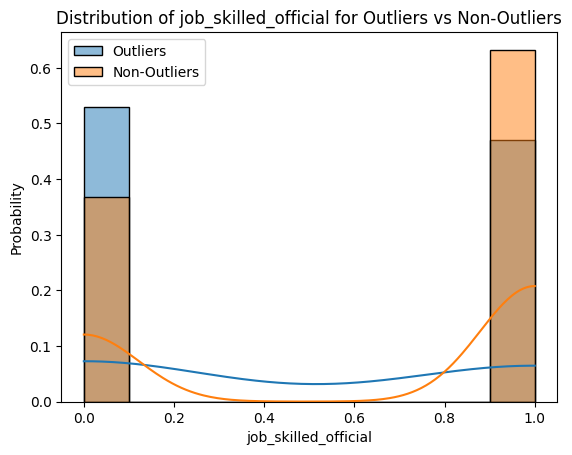

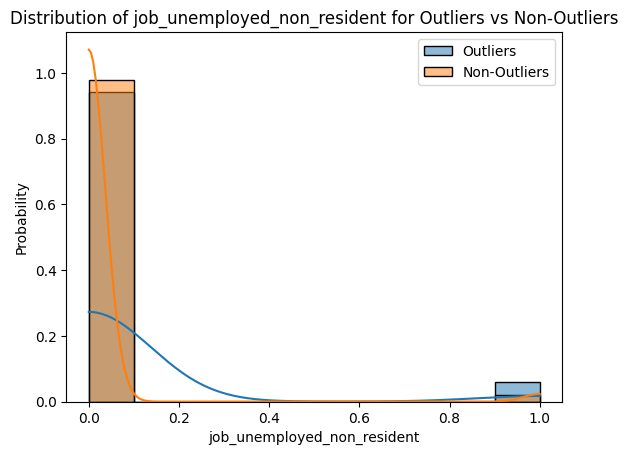

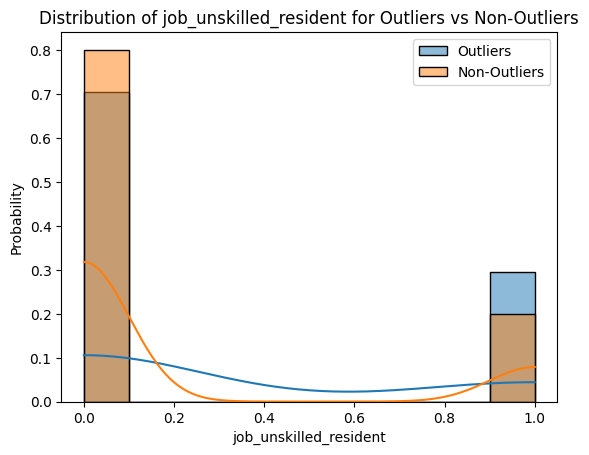

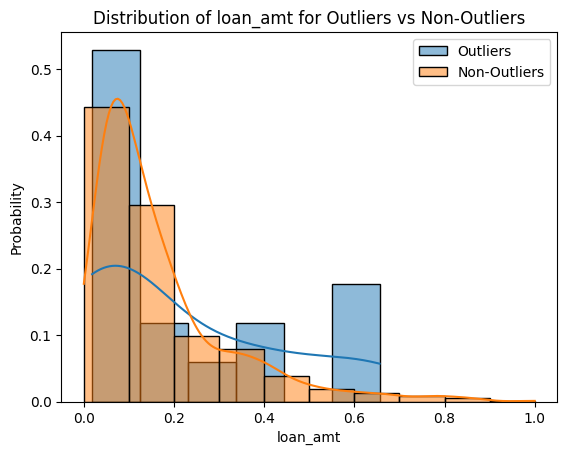

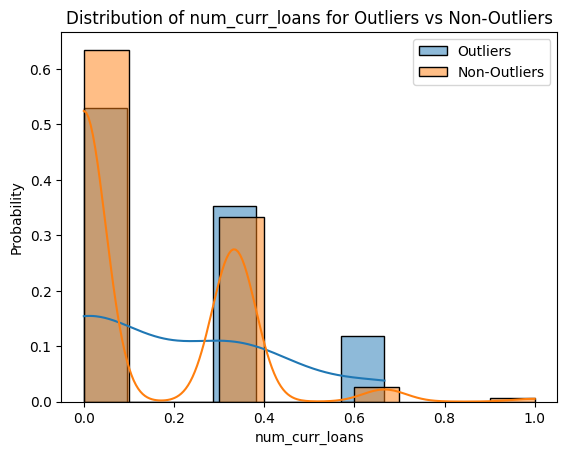

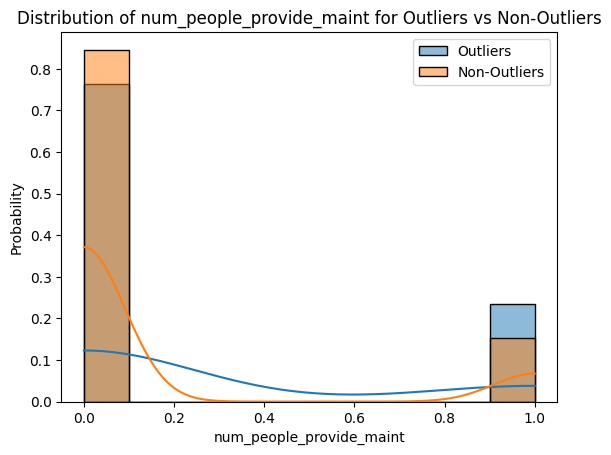

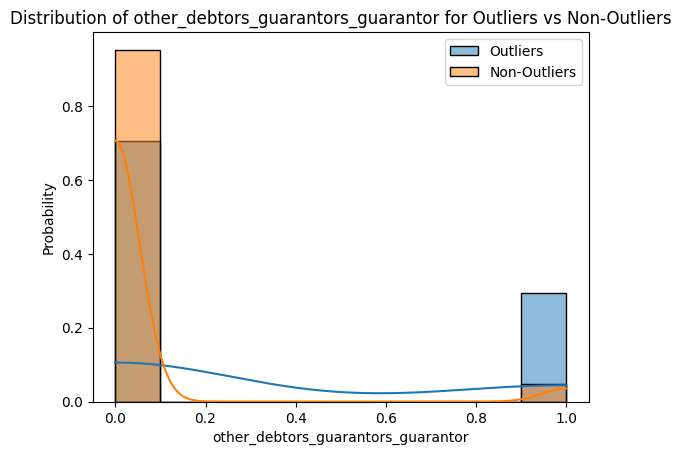

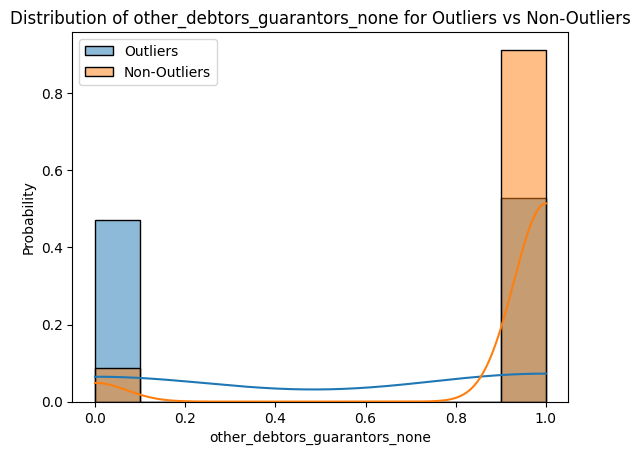

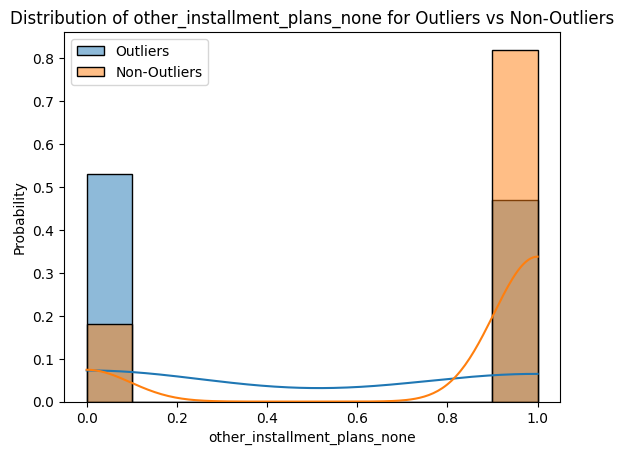

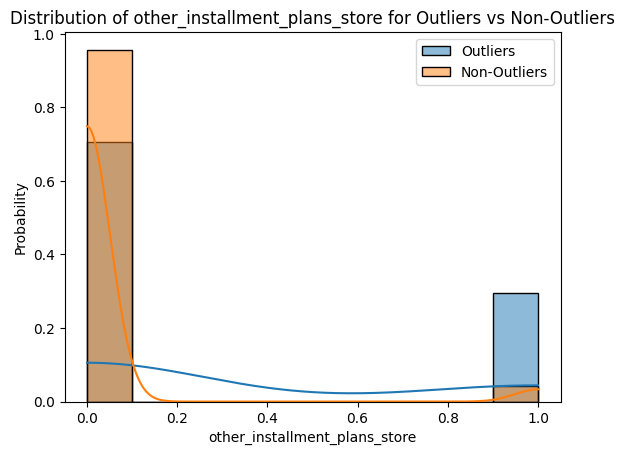

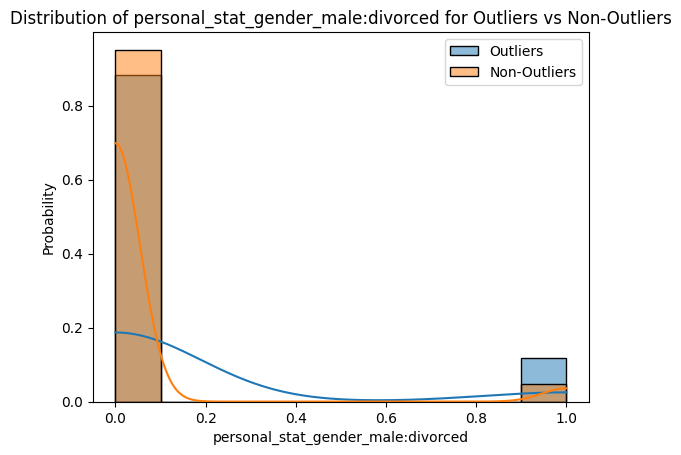

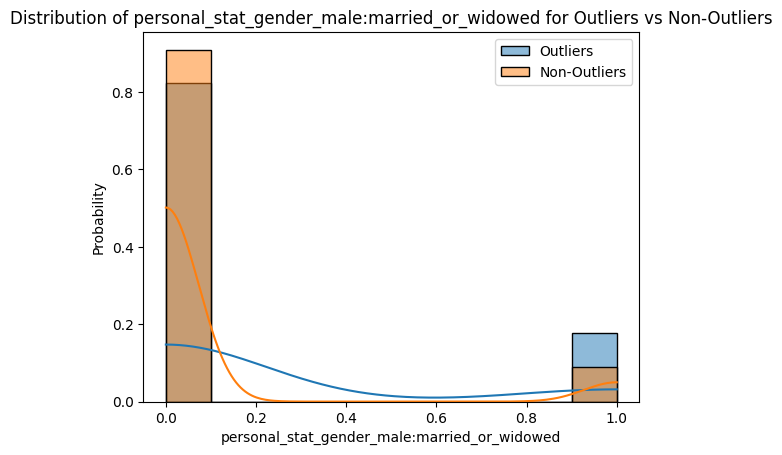

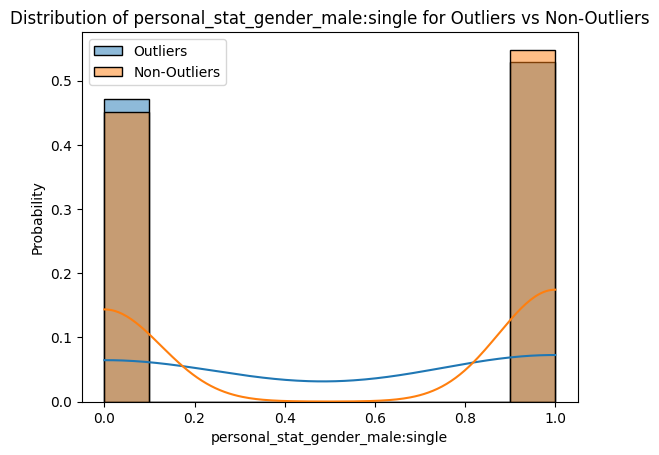

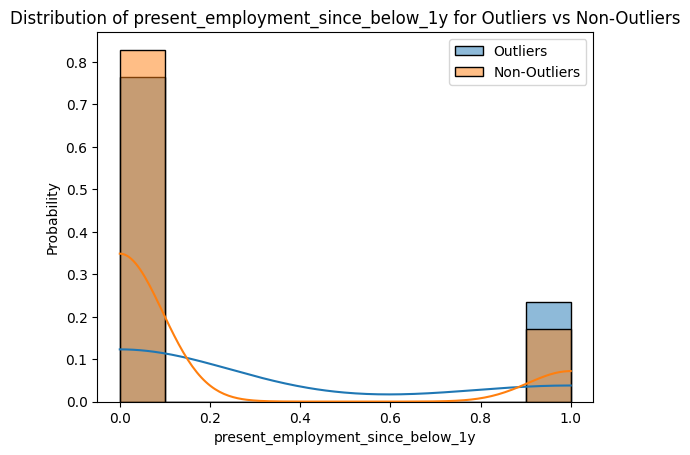

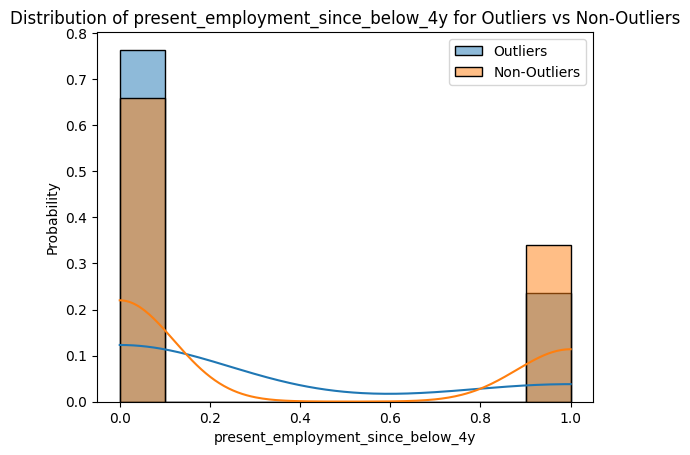

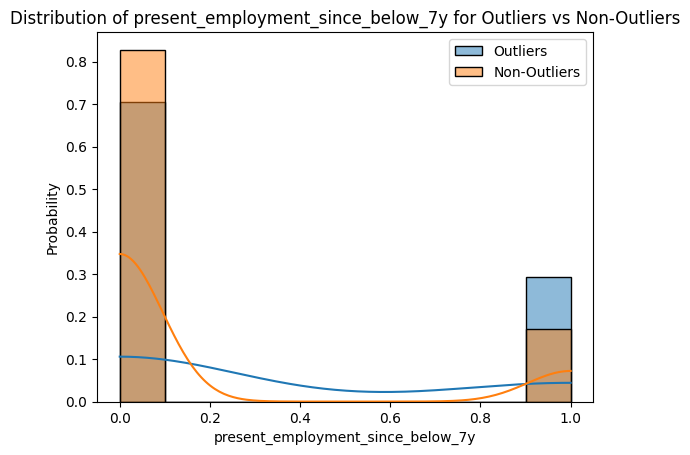

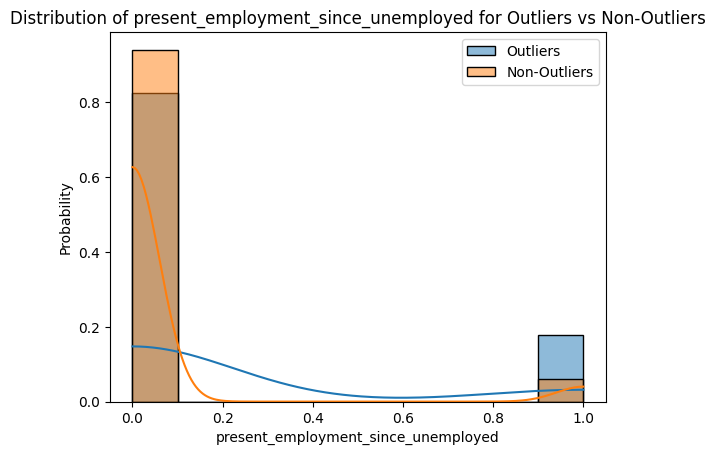

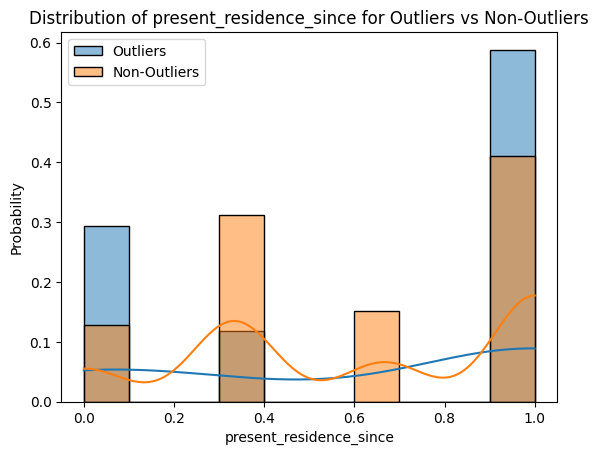

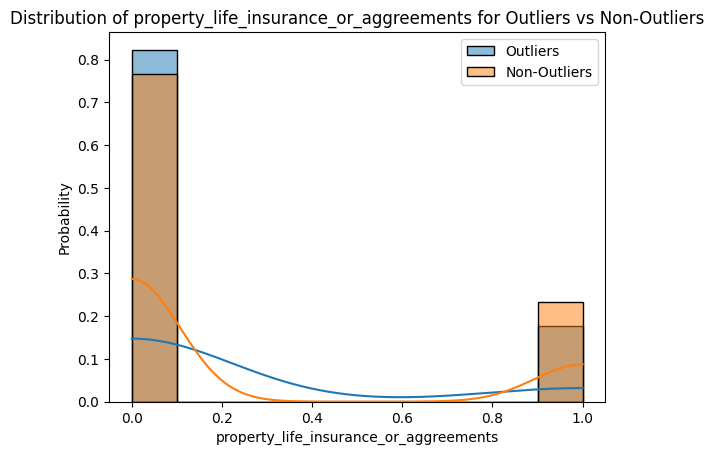

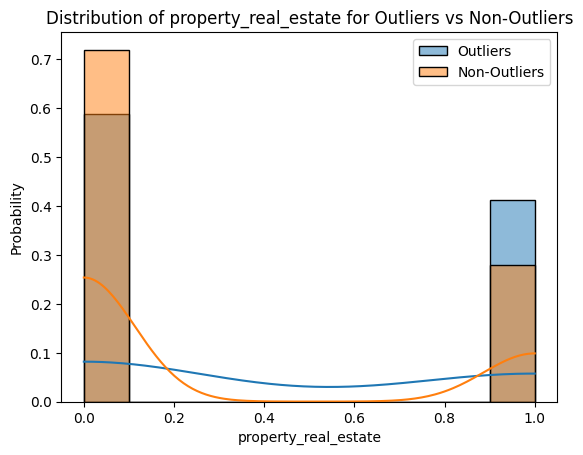

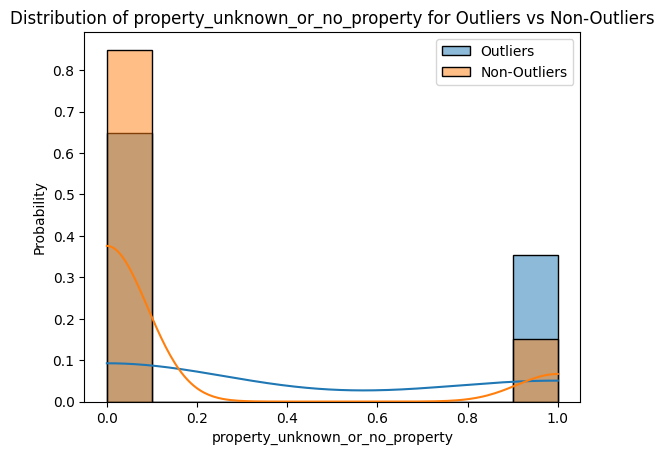

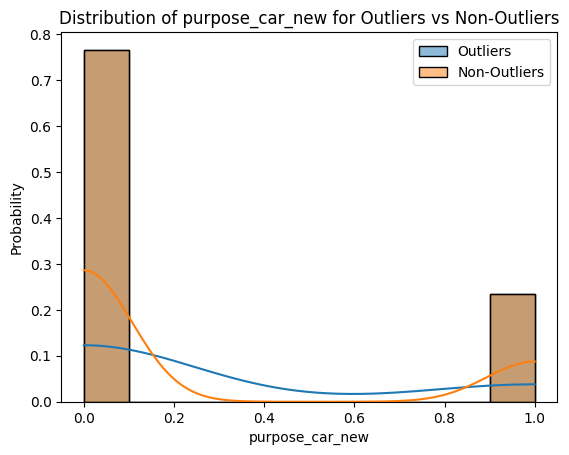

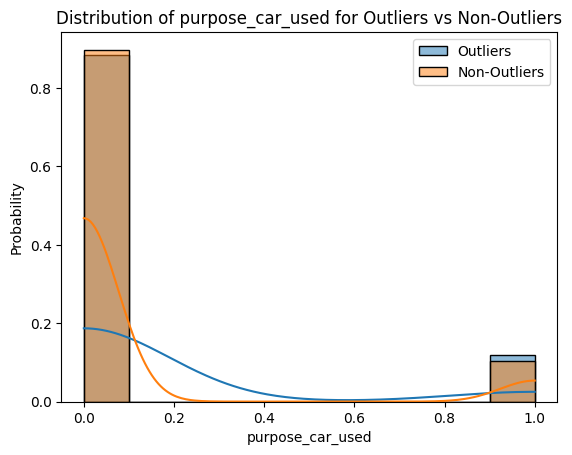

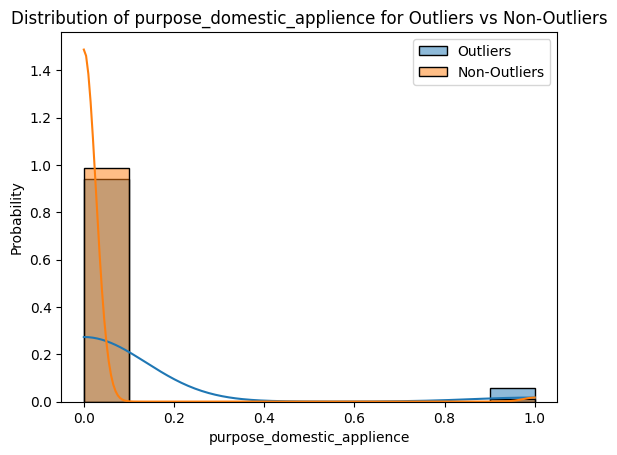

ValueError: `bins` must be positive, when an integer

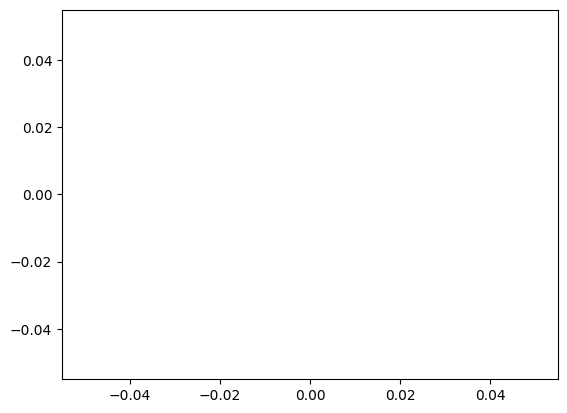

In [11]:
'''
We initialize a One-Class SVM algorithm with nu=0.01. This parameter acts as an upper bound for the fraction of outliers
and as a lower bound on the fraction of support vectors in the model. Given the low standard deviations of the columns 
as shown above, it is hard for the model to find meaningful outliers. Genuine anomalies are rare. Therefore, we modify the 
default value of 0.5 to 0.01 (constituting approximately 1% of the data points) to tell the model to try to focus only on 
the most extreme outliers.

An interesting insight from the 17 outliers provided by the One-Class SVM is that 15 out of those 17 borrowers are
foreign workers. However, in the whole dataset, 963 out of the 1000 borrowers are foreign workers. There is a 
substantially higher proportion of non-foreign workers in the outliers (2/17 ≈ 11.75%) vs the dataset (37/1000 = 3.7%).

Generalizing this process to all attributes in the table, we can analyze each column individually this way:
'''
data['outlier'] = [x == -1 for x in svm.predict(data)]

# Visualize outliers with normalized proportion histograms for all features.
for column in data.columns.difference(['outlier']):
    seaborn.histplot(data[data['outlier']][column], binwidth=0.1, label='Outliers', kde=True, stat="probability")
    seaborn.histplot(data[~data['outlier']][column], binwidth=0.1, label='Non-Outliers', kde=True, stat="probability")
    matplotlib.pyplot.title(f'Distribution of {column} for Outliers vs Non-Outliers')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()
'''
Overall, the variables with the largest proportion difference were non-foreign workers as well as borrowers with guarantors.
This finding suggests potential biases or unique circumstances affecting non-foreign workers' financial behavior, possibly 
influencing their representation in outlier data. Moreover, the presence of borrowers with guarantors among outliers 
underlines another dimension of atypical financial activity, as this characteristic is exceptionally rare in the dataset.
'''

In [ ]:
# After removing the outliers produced by the One-Class SVM Model, there are no redundant attributes left and the dataset 
# of 983 rows should is ready to do be used for classification using supervised learning.